<a href="https://colab.research.google.com/github/kumuds4/BCH/blob/master/Making_the_Most_of_your_Colab_Subscription_(34).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making the Most of your Colab Subscription



## Faster GPUs

Users who have purchased one of Colab's paid plans have access to faster GPUs and more memory. You can upgrade your notebook's GPU settings in `Runtime > Change runtime type` in the menu to select from several accelerator options, subject to availability.

The free of charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is "Not connected to a GPU", you can change the runtime by going to `Runtime > Change runtime type` in the menu to enable a GPU accelerator, and then re-execute the code cell.


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In order to use a GPU with your notebook, select the `Runtime > Change runtime type` menu, and then set the hardware accelerator to the desired option.

## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available. More powerful GPUs are always offered with high-memory VMs.



You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.


In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

## Longer runtimes

All Colab runtimes are reset after some period of time (which is faster if the runtime isn't executing code). Colab Pro and Pro+ users have access to longer runtimes than those who use Colab free of charge.

## Background execution

Colab Pro+ users have access to background execution, where notebooks will continue executing even after you've closed a browser tab. This is always enabled in Pro+ runtimes as long as you have compute units available.



## Relaxing resource limits in Colab Pro

Your resources are not unlimited in Colab. To make the most of Colab, avoid using resources when you don't need them. For example, only use a GPU when required and close Colab tabs when finished.



If you encounter limitations, you can relax those limitations by purchasing more compute units via Pay As You Go. Anyone can purchase compute units via [Pay As You Go](https://colab.research.google.com/signup); no subscription is required.

## Send us feedback!

If you have any feedback for us, please let us know. The best way to send feedback is by using the Help > 'Send feedback...' menu. If you encounter usage limits in Colab Pro consider subscribing to Pro+.

If you encounter errors or other issues with billing (payments) for Colab Pro, Pro+, or Pay As You Go, please email [colab-billing@google.com](mailto:colab-billing@google.com).

## More Resources

### Working with Notebooks in Colab
- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<a name="working-with-data"></a>
### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)


<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TPUs in Colab](/notebooks/tpu.ipynb)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# --- Parameters ---
N = 128                 # Polar code block length
K = 64                  # Number of information bits (excluding CRC)
CRC_LEN = 8             # CRC length in bits
LIST_SIZE = 8           # List size for SCL decoder
SNR_DB_RANGE = np.arange(0, 4.5, 0.5)  # SNR range in dB for simulation

NUM_FRAMES = 1000       # Number of frames per SNR for simulation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- CRC Functions (simple CRC-8) ---
CRC_POLY = 0x07  # x^8 + x^2 + x + 1

def crc_encode(info_bits):
    """ Append CRC bits to info_bits (numpy array of 0/1). """
    data = np.concatenate([info_bits, np.zeros(CRC_LEN, dtype=int)])
    for i in range(len(info_bits)):
        if data[i] == 1:
            for j in range(CRC_LEN + 1):
                if ((CRC_POLY >> j) & 1):
                    data[i + j] ^= 1
    return np.concatenate([info_bits, data[-CRC_LEN:]])

def crc_check(codeword):
    """ Check CRC of codeword (info+CRC). Return True if passes. """
    data = codeword.copy()
    for i in range(len(codeword) - CRC_LEN):
        if data[i] == 1:
            for j in range(CRC_LEN + 1):
                if ((CRC_POLY >> j) & 1):
                    data[i + j] ^= 1
    return np.all(data[-CRC_LEN:] == 0)

# --- Polar code construction (using reliability sequence for N=128) ---
# Source: Arikan's polar sequence for N=128 (from 5G standards or literature)
# The lower the index in this sequence, the more reliable the bit channel
polar_reliability_sequence = [
     0,  1,  2,  4,  8,  16,  3,  5,
     9,  6,  10,  12,  17,  24,  7,  11,
     13,  18,  25,  20,  26,  28,  14,  19,
     21,  22,  27,  29,  30,  31,  15,  23,
     32,  33,  34,  36,  40,  48,  35,  37,
     41,  38,  42,  44,  49,  56,  39,  43,
     45,  50,  57,  52,  58,  60,  46,  51,
     53,  54,  59,  61,  62,  63,  47,  55,
     64,  65,  66,  68,  72,  80,  67,  69,
     73,  70,  74,  76,  81,  88,  71,  75,
     77,  82,  89,  84,  90,  92,  78,  83,
     85,  86,  91,  93,  94,  95,  79,  87,
     96,  97,  98, 100, 104, 112,  99, 101,
    105, 102, 106, 108, 113, 120, 103, 107,
    109, 114, 121, 116, 122, 124, 110, 115,
    117, 118, 123, 125, 126, 127, 111, 119
]

# Select frozen and information bit indices
info_bits_indices = sorted(polar_reliability_sequence[:K + CRC_LEN])
frozen_bits_indices = sorted(set(range(N)) - set(info_bits_indices))

# --- Polar transform (encoder) ---
def polar_transform(u):
    """Apply Polar transform recursively."""
    N = len(u)
    if N == 1:
        return u
    else:
        u1 = (u[0:N//2] ^ u[N//2:N])
        u2 = u[N//2:N]
        return np.concatenate([polar_transform(u1), polar_transform(u2)])

def polar_encode(info_bits):
    """Encode info bits with CRC and frozen bits, apply polar transform."""
    # Append CRC bits
    info_crc = crc_encode(info_bits)
    u = np.zeros(N, dtype=int)
    u[info_bits_indices] = info_crc
    return polar_transform(u)

# --- BPSK Modulation and AWGN Channel ---
def bpsk_modulation(x):
    return 1 - 2*x  # 0->+1, 1->-1

def awgn_channel(x, snr_db):
    snr = 10**(snr_db/10)
    sigma = np.sqrt(1/(2*snr))
    noise = sigma * np.random.randn(*x.shape)
    return x + noise, sigma

# --- LLR calculation for BPSK over AWGN ---
def llr_awgn(y, sigma):
    return 2 * y / (sigma**2)

# --- SC Decoder ---
def sc_decode(llr, frozen_bits_indices):
    """Successive Cancellation decoder."""
    N = len(llr)
    n = int(np.log2(N))
    # Initialize arrays
    u_hat = np.zeros(N, dtype=int)

    def recursive_decode(llr_sub, depth, offset):
        if depth == 0:
            # Leaf node
            idx = offset
            if idx in frozen_bits_indices:
                return 0
            else:
                return 0 if llr_sub >= 0 else 1
        else:
            half = 2**(depth - 1)
            llr_left = f_func(llr_sub[:half], llr_sub[half:])
            left_bits = [recursive_decode(llr_left, depth-1, offset)]
            llr_right = g_func(llr_sub[:half], llr_sub[half:], left_bits[0])
            right_bits = [recursive_decode(llr_right, depth-1, offset + half)]
            return left_bits + right_bits

    def f_func(a, b):
        return np.sign(a)*np.sign(b)*np.minimum(np.abs(a), np.abs(b))

    def g_func(a, b, c):
        return b + (1 - 2*c)*a

    bits = recursive_decode(llr, n, 0)
    return np.array(bits)

# --- CRC-Aided SCL Decoder ---
# For brevity, we implement a simplified version of SCL without path pruning
# In practice, use optimized libraries, but here is a basic version

class Node:
    def __init__(self, llr, path, metric):
        self.llr = llr
        self.path = path
        self.metric = metric

def scl_decode(llr, frozen_bits_indices, list_size=LIST_SIZE):
    N = len(llr)
    n = int(np.log2(N))

    paths = [([], 0.0)]  # List of (decoded bits, path metric)
    for i in range(N):
        new_paths = []
        for path, metric in paths:
            # If frozen bit, only one choice
            if i in frozen_bits_indices:
                bit = 0
                # Update metric with log likelihood
                llr_i = llr[i]
                metric_new = metric + (0 if bit == (llr_i >= 0) else abs(llr_i))
                new_paths.append((path + [bit], metric_new))
            else:
                # For info bits, consider both 0 and 1
                for bit in [0, 1]:
                    llr_i = llr[i]
                    metric_new = metric + (0 if bit == (llr_i >= 0) else abs(llr_i))
                    new_paths.append((path + [bit], metric_new))
        # Keep only best list_size paths
        new_paths.sort(key=lambda x: x[1])
        paths = new_paths[:list_size]

    # CRC check for paths, choose the first passing CRC or best metric
    for path, metric in paths:
        # Extract info+CRC bits
        info_crc_bits = np.array(path)[info_bits_indices]
        if crc_check(info_crc_bits):
            return np.array(path)
    # No CRC passed, return best path
    return np.array(paths[0][0])

# --- Simple RNN Decoder using PyTorch ---
class SimpleRNNDecoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(SimpleRNNDecoder, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        out, _ = self.rnn(x)
        out = self.fc(out)
        out = self.sigmoid(out)
        return out.squeeze(-1)

# --- Training and Evaluation Functions ---
def generate_data(num_frames):
    """Generate random info bits and encode with CRC and polar."""
    info_bits = np.random.randint(0, 2, (num_frames, K))
    coded_bits = np.array([polar_encode(ib) for ib in info_bits])
    return info_bits, coded_bits

def simulate_channel(coded_bits, snr_db):
    """BPSK modulate, add noise, return received signal and LLRs."""
    tx_signal = bpsk_modulation(coded_bits)
    rx_signal, sigma = awgn_channel(tx_signal, snr_db)
    llrs = llr_awgn(rx_signal, sigma)
    return rx_signal, llrs, sigma

def evaluate_decoder(decoder_func, info_bits, coded_bits, frozen_bits_indices, snr_db):
    """Evaluate given decoder function over frames."""
    total_bit_errors = 0
    total_block_errors = 0
    num_frames = len(info_bits)
    for i in range(num_frames):
        # Channel simulation
        _, llr, _ = simulate_channel(coded_bits[i:i+1], snr_db)
        llr = llr[0]
        # Decode
        decoded = decoder_func(llr, frozen_bits_indices)
        # Extract info+CRC bits
        decoded_info_crc = decoded[info_bits_indices]
        # Count errors
        bit_errors = np.sum(decoded_info_crc[:K] != info_bits[i])
        total_bit_errors += bit_errors
        total_block_errors += (bit_errors > 0)
    ber = total_bit_errors / (num_frames * K)
    bler = total_block_errors / num_frames
    return ber, bler

def evaluate_rnn_decoder(model, info_bits, coded_bits, snr_db, batch_size=32):
    model.eval()
    total_bit_errors = 0
    total_block_errors = 0
    num_frames = len(info_bits)
    sigma = np.sqrt(1/(2*(10**(snr_db/10))))
    with torch.no_grad():
        for i in range(0, num_frames, batch_size):
            batch_coded = coded_bits[i:i+batch_size]
            batch_info = info_bits[i:i+batch_size]
            batch_size_curr = len(batch_coded)
            tx_signal = bpsk_modulation(batch_coded)
            noise = sigma * np.random.randn(*tx_signal.shape)
            rx_signal = tx_signal + noise
            llr = 2 * rx_signal / (sigma**2)
            # Prepare input tensor for RNN: (batch, seq_len, input_size=1)
            input_tensor = torch.tensor(llr, dtype=torch.float32, device=device).unsqueeze(-1)
            outputs = model(input_tensor)
            outputs = outputs.cpu().numpy()
            # Hard decision threshold 0.5
            decoded_bits = (outputs < 0.5).astype(int)
            for j in range(batch_size_curr):
                decoded_info_crc = decoded_bits[j, info_bits_indices]
                bit_errors = np.sum(decoded_info_crc[:K] != batch_info[j])
                total_bit_errors += bit_errors
                total_block_errors += (bit_errors > 0)
    ber = total_bit_errors / (num_frames * K)
    bler = total_block_errors / num_frames
    return ber, bler

# --- Main Simulation and Plotting ---
def main():
    print(f'Running simulation on device: {device}')
    # Generate dataset for simulation
    info_bits_all, coded_bits_all = generate_data(NUM_FRAMES)

    # Evaluate SC and SCL decoders
    ber_sc = []
    bler_sc = []
    ber_scl = []
    bler_scl = []

    for snr_db in SNR_DB_RANGE:
        print(f'Simulating at SNR = {snr_db} dB...')
        ber_tmp, bler_tmp = evaluate_decoder(sc_decode, info_bits_all, coded_bits_all, frozen_bits_indices, snr_db)
        ber_sc.append(ber_tmp)
        bler_sc.append(bler_tmp)
        ber_tmp, bler_tmp = evaluate_decoder(lambda llr, f: scl_decode(llr, f, list_size=LIST_SIZE),
                                             info_bits_all, coded_bits_all, frozen_bits_indices, snr_db)
        ber_scl.append(ber_tmp)
        bler_scl.append(bler_tmp)

    # --- Train simple RNN decoder ---
    print('Training RNN decoder (this may take a moment)...')
    rnn_model = SimpleRNNDecoder().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
    epochs = 3  # For demo, increase for better performance
    batch_size = 64

    # Prepare training data
    train_info, train_coded = generate_data(2000)
    sigma_train = np.sqrt(1/(2*(10**(1.5))))  # Fixed training SNR at 1.5 dB

    rnn_model.train()
    for epoch in range(epochs):
        perm = np.random.permutation(len(train_info))
        epoch_loss = 0
        for i in range(0, len(train_info), batch_size):
            idx = perm[i:i+batch_size]
            batch_info = train_info[idx]
            batch_coded = train_coded[idx]
            tx_signal = bpsk_modulation(batch_coded)
            noise = sigma_train * np.random.randn(*tx_signal.shape)
            rx_signal = tx_signal + noise
            llr = 2 * rx_signal / (sigma_train**2)
            # Inputs: LLRs, Targets: coded bits
            inputs = torch.tensor(llr, dtype=torch.float32, device=device).unsqueeze(-1)
            targets = torch.tensor(batch_coded, dtype=torch.float32, device=device)
            optimizer.zero_grad()
            outputs = rnn_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

    # Evaluate RNN decoder
    ber_rnn = []
    bler_rnn = []
    for snr_db in SNR_DB_RANGE:
        print(f'Evaluating RNN at SNR = {snr_db} dB...')
        ber_tmp, bler_tmp = evaluate_rnn_decoder(rnn_model, info_bits_all, coded_bits_all, snr_db)
        ber_rnn.append(ber_tmp)
        bler_rnn.append(bler_tmp)

    # --- Plot BER/BLER ---
    plt.figure(figsize=(10,6))
    plt.semilogy(SNR_DB_RANGE, ber_sc, 'o-', label='SC Decoder BER')
    plt.semilogy(SNR_DB_RANGE, bler_sc, 'o--', label='SC Decoder BLER')
    plt.semilogy(SNR_DB_RANGE, ber_scl, 's-', label=f'SCL Decoder (L={LIST_SIZE}) BER')
    plt.semilogy(SNR_DB_RANGE, bler_scl, 's--', label=f'SCL Decoder (L={LIST_SIZE}) BLER')
    plt.semilogy(SNR_DB_RANGE, ber_rnn, 'd-', label='RNN Decoder BER')
    plt.semilogy(SNR_DB_RANGE, bler_rnn, 'd--', label='RNN Decoder BLER')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Error Rate')
    plt.title('Polar Code BER/BLER Simulation')
    plt.grid(True, which='both')
    plt.legend()
    plt.ylim(1e-4, 1)
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# --- Parameters ---
N = 128                 # Polar code block length
K = 64                  # Number of information bits (excluding CRC)
CRC_LEN = 8             # CRC length in bits
LIST_SIZE = 8           # List size for SCL decoder
SNR_DB_RANGE = np.arange(0, 4.5, 0.5)  # SNR range in dB for simulation

NUM_FRAMES = 1000       # Number of frames per SNR for simulation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- CRC Functions (simple CRC-8) ---
CRC_POLY = 0x07  # x^8 + x^2 + x + 1

def crc_encode(info_bits):
    data = np.concatenate([info_bits, np.zeros(CRC_LEN, dtype=int)])
    for i in range(len(info_bits)):
        if data[i] == 1:
            for j in range(CRC_LEN + 1):
                if ((CRC_POLY >> j) & 1):
                    data[i + j] ^= 1
    return np.concatenate([info_bits, data[-CRC_LEN:]])

def crc_check(codeword):
    data = codeword.copy()
    for i in range(len(codeword) - CRC_LEN):
        if data[i] == 1:
            for j in range(CRC_LEN + 1):
                if ((CRC_POLY >> j) & 1):
                    data[i + j] ^= 1
    return np.all(data[-CRC_LEN:] == 0)

# --- Polar code construction ---
polar_reliability_sequence = [
     0,  1,  2,  4,  8,  16,  3,  5,
     9,  6,  10,  12,  17,  24,  7,  11,
     13,  18,  25,  20,  26,  28,  14,  19,
     21,  22,  27,  29,  30,  31,  15,  23,
     32,  33,  34,  36,  40,  48,  35,  37,
     41,  38,  42,  44,  49,  56,  39,  43,
     45,  50,  57,  52,  58,  60,  46,  51,
     53,  54,  59,  61,  62,  63,  47,  55,
     64,  65,  66,  68,  72,  80,  67,  69,
     73,  70,  74,  76,  81,  88,  71,  75,
     77,  82,  89,  84,  90,  92,  78,  83,
     85,  86,  91,  93,  94,  95,  79,  87,
     96,  97,  98, 100, 104, 112,  99, 101,
    105, 102, 106, 108, 113, 120, 103, 107,
    109, 114, 121, 116, 122, 124, 110, 115,
    117, 118, 123, 125, 126, 127, 111, 119
]

info_bits_indices = sorted(polar_reliability_sequence[:K + CRC_LEN])
frozen_bits_indices = sorted(set(range(N)) - set(info_bits_indices))

# --- Polar transform ---
def polar_transform(u):
    N = len(u)
    if N == 1:
        return u
    else:
        u1 = (u[0:N//2] ^ u[N//2:N])
        u2 = u[N//2:N]
        return np.concatenate([polar_transform(u1), polar_transform(u2)])

def polar_encode(info_bits):
    info_crc = crc_encode(info_bits)
    u = np.zeros(N, dtype=int)
    u[info_bits_indices] = info_crc
    return polar_transform(u)

# --- BPSK and Channel ---
def bpsk_modulation(x):
    return 1 - 2*x

def awgn_channel(x, snr_db):
    snr = 10**(snr_db/10)
    sigma = np.sqrt(1/(2*snr))
    noise = sigma * np.random.randn(*x.shape)
    return x + noise, sigma

def llr_awgn(y, sigma):
    return 2 * y / (sigma**2)

# --- SC Decoder ---
def sc_decode(llr, frozen_bits_indices):
    N = len(llr)
    n = int(np.log2(N))

    def f_func(a, b):
        return np.sign(a)*np.sign(b)*np.minimum(np.abs(a), np.abs(b))

    def g_func(a, b, c):
        return b + (1 - 2*c)*a

    def recursive_decode(llr_sub, depth, offset):
        if depth == 0:
            idx = offset
            if idx in frozen_bits_indices:
                return [0]
            else:
                return [0] if llr_sub >= 0 else [1]
        else:
            half = 2**(depth - 1)
            llr_left = f_func(llr_sub[:half], llr_sub[half:])
            left_bits = recursive_decode(llr_left, depth-1, offset)
            llr_right = g_func(llr_sub[:half], llr_sub[half:], left_bits[0])
            right_bits = recursive_decode(llr_right, depth-1, offset + half)
            return left_bits + right_bits

    bits = recursive_decode(llr, n, 0)
   # return np.array(bits)
    return np.array(bits)[info_indices]

    def f_func(a, b):
        return np.sign(a)*np.sign(b)*np.minimum(np.abs(a), np.abs(b))

    def g_func(a, b, c):
        return b + (1 - 2*c)*a

    bits = recursive_decode(llr, n, 0)
    return np.array(bits)

# --- SCL Decoder (simplified) ---
def scl_decode(llr, frozen_bits_indices, list_size=LIST_SIZE):
    N = len(llr)

    paths = [([], 0.0)]
    for i in range(N):
        new_paths = []
        for path, metric in paths:
            if i in frozen_bits_indices:
                bit = 0
                llr_i = llr[i]
                metric_new = metric + (0 if bit == (llr_i >= 0) else abs(llr_i))
                new_paths.append((path + [bit], metric_new))
            else:
                for bit in [0, 1]:
                    llr_i = llr[i]
                    metric_new = metric + (0 if bit == (llr_i >= 0) else abs(llr_i))
                    new_paths.append((path + [bit], metric_new))
        new_paths.sort(key=lambda x: x[1])
        paths = new_paths[:list_size]

    for path, metric in paths:
        info_crc_bits = np.array(path)[info_bits_indices]
        if crc_check(info_crc_bits):
            return np.array(path)
   # return np.array(paths[0][0])
    return code[info_indices]

# --- Simple RNN Decoder ---
class SimpleRNNDecoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(SimpleRNNDecoder, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        out = self.sigmoid(out)
        return out.squeeze(-1)

# --- Data generation and simulation ---
def generate_data(num_frames):
    info_bits = np.random.randint(0, 2, (num_frames, K))
    coded_bits = np.array([polar_encode(ib) for ib in info_bits])
    return info_bits, coded_bits

def evaluate_decoder(decoder_func, info_bits, coded_bits, frozen_bits_indices, snr_db):
    total_bit_errors = 0
    total_block_errors = 0
    num_frames = len(info_bits)
    for i in range(num_frames):
        _, llr, _ = simulate_channel(coded_bits[i:i+1], snr_db)
        llr = llr[0]
        decoded = decoder_func(llr, frozen_bits_indices)
        decoded_info_crc = decoded[info_bits_indices]
        bit_errors = np.sum(decoded_info_crc[:K] != info_bits[i])
        total_bit_errors += bit_errors
        total_block_errors += (bit_errors > 0)
    ber = total_bit_errors / (num_frames * K)
    bler = total_block_errors / num_frames
    return ber, bler

def simulate_channel(coded_bits, snr_db):
    tx_signal = bpsk_modulation(coded_bits)
    rx_signal, sigma = awgn_channel(tx_signal, snr_db)
    llrs = llr_awgn(rx_signal, sigma)
    return rx_signal, llrs, sigma

def evaluate_rnn_decoder(model, info_bits, coded_bits, snr_db, batch_size=32):
    model.eval()
    total_bit_errors = 0
    total_block_errors = 0
    num_frames = len(info_bits)
    sigma = np.sqrt(1/(2*(10**(snr_db/10))))
    with torch.no_grad():
        for i in range(0, num_frames, batch_size):
            batch_coded = coded_bits[i:i+batch_size]
            batch_info = info_bits[i:i+batch_size]
            batch_size_curr = len(batch_coded)
            tx_signal = bpsk_modulation(batch_coded)
            noise = sigma * np.random.randn(*tx_signal.shape)
            rx_signal = tx_signal + noise
            llr = 2 * rx_signal / (sigma**2)
            input_tensor = torch.tensor(llr, dtype=torch.float32, device=device).unsqueeze(-1)
            outputs = model(input_tensor)
            outputs = outputs.cpu().numpy()
            decoded_bits = (outputs < 0.5).astype(int)
            for j in range(batch_size_curr):
                decoded_info_crc = decoded_bits[j, info_bits_indices]
                bit_errors = np.sum(decoded_info_crc[:K] != batch_info[j])
                total_bit_errors += bit_errors
                total_block_errors += (bit_errors > 0)
    ber = total_bit_errors / (num_frames * K)
    bler = total_block_errors / num_frames
    return ber, bler

# --- Main function ---
def main():
    print(f'Running simulation on device: {device}')
    info_bits_all, coded_bits_all = generate_data(NUM_FRAMES)

    # SC and SCL evaluation
    ber_sc, bler_sc = [], []
    ber_scl, bler_scl = [], []

    for snr_db in SNR_DB_RANGE:
        print(f'Simulating SC and SCL at SNR={snr_db} dB...')
        ber_tmp, bler_tmp = evaluate_decoder(sc_decode, info_bits_all, coded_bits_all, frozen_bits_indices, snr_db)
        ber_sc.append(ber_tmp)
        bler_sc.append(bler_tmp)
        ber_tmp, bler_tmp = evaluate_decoder(lambda llr, f: scl_decode(llr, f, list_size=LIST_SIZE),
                                             info_bits_all, coded_bits_all, frozen_bits_indices, snr_db)
        ber_scl.append(ber_tmp)
        bler_scl.append(bler_tmp)

    # RNN training with train/validation split and plotting
    print('Training RNN decoder (with train/validation split)...')

    train_info_all, train_coded_all = generate_data(2000)
    split_idx = int(0.8 * len(train_info_all))
    train_info, val_info = train_info_all[:split_idx], train_info_all[split_idx:]
    train_coded, val_coded = train_coded_all[:split_idx], train_coded_all[split_idx:]

    sigma_train = np.sqrt(1/(2*(10**(1.5))))  # Fixed training SNR

    train_losses = []
    val_losses = []

    rnn_model = SimpleRNNDecoder().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
    epochs = 3
    batch_size = 64

    for epoch in range(epochs):
        rnn_model.train()
        perm = np.random.permutation(len(train_info))
        epoch_train_loss = 0
        for i in range(0, len(train_info), batch_size):
            idx = perm[i:i+batch_size]
            batch_info = train_info[idx]
            batch_coded = train_coded[idx]
            tx_signal = bpsk_modulation(batch_coded)
            noise = sigma_train * np.random.randn(*tx_signal.shape)
            rx_signal = tx_signal + noise
            llr = 2 * rx_signal / (sigma_train**2)
            inputs = torch.tensor(llr, dtype=torch.float32, device=device).unsqueeze(-1)
            targets = torch.tensor(batch_coded, dtype=torch.float32, device=device)
            optimizer.zero_grad()
            outputs = rnn_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        avg_train_loss = epoch_train_loss / (len(train_info) / batch_size)
        train_losses.append(avg_train_loss)

        rnn_model.eval()
        with torch.no_grad():
            val_loss = 0
            for i in range(0, len(val_info), batch_size):
                batch_info = val_info[i:i+batch_size]
                batch_coded = val_coded[i:i+batch_size]
                tx_signal = bpsk_modulation(batch_coded)
                noise = sigma_train * np.random.randn(*tx_signal.shape)
                rx_signal = tx_signal + noise
                llr = 2 * rx_signal / (sigma_train**2)
                inputs = torch.tensor(llr, dtype=torch.float32, device=device).unsqueeze(-1)
                targets = torch.tensor(batch_coded, dtype=torch.float32, device=device)
                outputs = rnn_model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
            avg_val_loss = val_loss / (len(val_info) / batch_size)
            val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), train_losses, 'b-o', label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, 'r-s', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (BCE)')
    plt.title('RNN Decoder Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate RNN decoder
    ber_rnn, bler_rnn = [], []
    for snr_db in SNR_DB_RANGE:
        print(f'Evaluating RNN decoder at SNR={snr_db} dB...')
        ber_tmp, bler_tmp = evaluate_rnn_decoder(rnn_model, info_bits_all, coded_bits_all, snr_db)
        ber_rnn.append(ber_tmp)
        bler_rnn.append(bler_tmp)

    # BER and BLER plot
    plt.figure(figsize=(10,6))
    plt.semilogy(SNR_DB_RANGE, ber_sc, 'o-', label='SC Decoder BER')
    plt.semilogy(SNR_DB_RANGE, bler_sc, 'o--', label='SC Decoder BLER')
    plt.semilogy(SNR_DB_RANGE, ber_scl, 's-', label=f'SCL Decoder (L={LIST_SIZE}) BER')
    plt.semilogy(SNR_DB_RANGE, bler_scl, 's--', label=f'SCL Decoder (L={LIST_SIZE}) BLER')
    plt.semilogy(SNR_DB_RANGE, ber_rnn, 'd-', label='RNN Decoder BER')
    plt.semilogy(SNR_DB_RANGE, bler_rnn, 'd--', label='RNN Decoder BLER')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Error Rate')
    plt.title('Polar Code BER/BLER Simulation')
    plt.grid(True, which='both')
    plt.legend()
    plt.ylim(1e-4, 1)
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
# Polar+CRC+SC+SCL+RNN Decoder Debug Version
# Fixed LLR scaling, decoder logic, and frozen set issues

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# --- Parameters ---
N = 128
K = 64
CRC_LEN = 8
LIST_SIZE = 8
DEBUG = True
SNR_DB_RANGE = [2.0] if DEBUG else np.arange(0, 4.5, 0.5)
NUM_FRAMES = 1 if DEBUG else 1000

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CRC
CRC_POLY = 0x07

def crc_encode(info_bits):
    data = np.concatenate([info_bits, np.zeros(CRC_LEN, dtype=int)])
    for i in range(len(info_bits)):
        if data[i] == 1:
            for j in range(CRC_LEN + 1):
                if ((CRC_POLY >> j) & 1):
                    data[i + j] ^= 1
    return np.concatenate([info_bits, data[-CRC_LEN:]])

def crc_check(codeword):
    data = codeword.copy()
    for i in range(len(codeword) - CRC_LEN):
        if data[i] == 1:
            for j in range(CRC_LEN + 1):
                if ((CRC_POLY >> j) & 1):
                    data[i + j] ^= 1
    return np.all(data[-CRC_LEN:] == 0)

# Polar construction
polar_reliability_sequence = np.argsort(np.random.rand(N))  # TEMP for demo only
info_indices = sorted(polar_reliability_sequence[:K + CRC_LEN])
frozen_indices = sorted(set(range(N)) - set(info_indices))

# Polar encoding

def polar_transform(u):
    N = len(u)
    if N == 1:
        return u
    else:
        u1 = (u[0:N//2] ^ u[N//2:N])
        u2 = u[N//2:N]
        return np.concatenate([polar_transform(u1), polar_transform(u2)])

def polar_encode(info_bits):
    info_crc = crc_encode(info_bits)
    u = np.zeros(N, dtype=int)
    u[info_indices] = info_crc
    return polar_transform(u)

# Channel

def bpsk_mod(x):
    return 1 - 2*x

def awgn_channel(x, snr_db):
    snr = 10**(snr_db/10)
    sigma = np.sqrt(1/(2*snr))
    noise = sigma * np.random.randn(*x.shape)
    return x + noise, sigma

def llr_awgn(y, sigma):
    return 2 * y / (sigma**2)

# SC Decoder

def sc_decode(llr, frozen_indices):
    N = len(llr)
    n = int(np.log2(N))

    def f(a, b):
        return np.sign(a) * np.sign(b) * np.minimum(np.abs(a), np.abs(b))

    def g(a, b, c):
        return b + (1 - 2*c) * a

    def recurse(llr, depth, offset):
        if depth == 0:
            idx = offset
            if idx in frozen_indices:
                return [0]
            else:
                return [0] if llr >= 0 else [1]
        half = 2**(depth - 1)
        left = recurse(f(llr[:half], llr[half:]), depth-1, offset)
        right = recurse(g(llr[:half], llr[half:], left[0]), depth-1, offset+half)
        return left + right

    bits = recurse(llr, n, 0)
   # return np.array(bits)[info_indices]
    return np.array(bits)

# SCL (basic)
def scl_decode(llr, frozen_indices, L=LIST_SIZE):
    N = len(llr)
    paths = [([], 0.0)]
    for i in range(N):
        new_paths = []
        for path, metric in paths:
            llr_i = llr[i]
            if i in frozen_indices:
                bit = 0
                metric_new = metric + (0 if bit == (llr_i >= 0) else abs(llr_i))
                new_paths.append((path + [bit], metric_new))
            else:
                for bit in [0, 1]:
                    metric_new = metric + (0 if bit == (llr_i >= 0) else abs(llr_i))
                    new_paths.append((path + [bit], metric_new))
        new_paths.sort(key=lambda x: x[1])
        paths = new_paths[:L]
    for path, _ in paths:
        code = np.array(path)
        if crc_check(code[info_indices]):
            #return code[info_indices]
            return code
    return np.array(paths[0][0])[info_indices]

# RNN Decoder
class RNNDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=64, num_layers=2, batch_first=True)
        self.fc = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return self.sigmoid(out).squeeze(-1)

# Main

def main():
    print("Device:", device)
    info_bits = np.random.randint(0, 2, (NUM_FRAMES, K))
    coded = np.array([polar_encode(b) for b in info_bits])

    for snr_db in SNR_DB_RANGE:
        tx = bpsk_mod(coded)
        rx, sigma = awgn_channel(tx, snr_db)
        llr = llr_awgn(rx, sigma)

        # SC
        sc_decoded = np.array([sc_decode(llr[i], frozen_indices) for i in range(NUM_FRAMES)])
        sc_info = sc_decoded[:, :K]

        # SCL
        scl_decoded = np.array([scl_decode(llr[i], frozen_indices) for i in range(NUM_FRAMES)])
        scl_info = scl_decoded[:, :K]

        ber_sc = np.mean(sc_info != info_bits)
        ber_scl = np.mean(scl_info != info_bits)


        if DEBUG:
            print("\n[DEBUG OUTPUT]")
            print("True:", info_bits[0])
            print("SC  :", sc_info[0])
            print("SCL :", scl_info[0])
            print("LLR :", np.round(llr[0], 2))

if __name__ == "__main__":
    main()


In [2]:
# Polar+CRC+SC+SCL Decoder with BER/BLER Plotting

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# --- Parameters ---
# --- Polar Code Parameters ---
BLOCK_LENGTH = 128
INFO_BITS = 64
CRC_BITS = 8
NUM_FRAMES = 300000  # For simulation

# --- Training Configuration ---
EPOCHS = 50
BATCH_SIZE = 512
TRAIN_SNR_DB = 2.0
VAL_SNR_DB = 2.0
LEARNING_RATE = 1e-3

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CRC
CRC_POLY = 0x07

def crc_encode(info_bits):
    data = np.concatenate([info_bits, np.zeros(CRC_LEN, dtype=int)])
    for i in range(len(info_bits)):
        if data[i] == 1:
            for j in range(CRC_LEN + 1):
                if ((CRC_POLY >> j) & 1):
                    data[i + j] ^= 1
    return np.concatenate([info_bits, data[-CRC_LEN:]])

def crc_check(codeword):
    data = codeword.copy()
    for i in range(len(codeword) - CRC_LEN):
        if data[i] == 1:
            for j in range(CRC_LEN + 1):
                if ((CRC_POLY >> j) & 1):
                    data[i + j] ^= 1
    return np.all(data[-CRC_LEN:] == 0)

# Polar construction
polar_reliability_sequence = np.argsort(np.random.rand(N))  # TEMP for demo only
info_indices = sorted(polar_reliability_sequence[:K + CRC_LEN])
frozen_indices = sorted(set(range(N)) - set(info_indices))

# Polar encoding

def polar_transform(u):
    N = len(u)
    if N == 1:
        return u
    else:
        u1 = (u[0:N//2] ^ u[N//2:N])
        u2 = u[N//2:N]
        return np.concatenate([polar_transform(u1), polar_transform(u2)])

def polar_encode(info_bits):
    info_crc = crc_encode(info_bits)
    u = np.zeros(N, dtype=int)
    u[info_indices] = info_crc
    return polar_transform(u)

# Channel

def bpsk_mod(x):
    return 1 - 2*x

def awgn_channel(x, snr_db):
    snr = 10**(snr_db/10)
    sigma = np.sqrt(1/(2*snr))
    noise = sigma * np.random.randn(*x.shape)
    return x + noise, sigma

def llr_awgn(y, sigma):
    return 2 * y / (sigma**2)

def compute_mutual_information(llrs, bits):
    # Clip llrs for numerical stability
    llrs = np.clip(llrs, -50, 50)
    # Calculate MI per bit, then average over all bits
    mi = 1 - np.mean(np.log2(1 + np.exp(-llrs * (1 - 2 * bits))))
    return mi
# SC Decoder

def sc_decode(llr, frozen_indices):
    N = len(llr)
    n = int(np.log2(N))

    def f(a, b):
        return np.sign(a) * np.sign(b) * np.minimum(np.abs(a), np.abs(b))

    def g(a, b, c):
        return b + (1 - 2*c) * a

    def recurse(llr, depth, offset):
        if depth == 0:
            idx = offset
            if idx in frozen_indices:
                return [0]
            else:
                return [0] if llr >= 0 else [1]
        half = 2**(depth - 1)
        left = recurse(f(llr[:half], llr[half:]), depth-1, offset)
        right = recurse(g(llr[:half], llr[half:], left[0]), depth-1, offset+half)
        return left + right

    bits = recurse(llr, n, 0)
    return np.array(bits)

# SCL (basic)
def scl_decode(llr, frozen_indices, L=LIST_SIZE):
    N = len(llr)
    paths = [([], 0.0)]
    for i in range(N):
        new_paths = []
        for path, metric in paths:
            llr_i = llr[i]
            if i in frozen_indices:
                bit = 0
                metric_new = metric + (0 if bit == (llr_i >= 0) else abs(llr_i))
                new_paths.append((path + [bit], metric_new))
            else:
                for bit in [0, 1]:
                    metric_new = metric + (0 if bit == (llr_i >= 0) else abs(llr_i))
                    new_paths.append((path + [bit], metric_new))
        new_paths.sort(key=lambda x: x[1])
        paths = new_paths[:L]
    for path, _ in paths:
        code = np.array(path)
        if crc_check(code[info_indices]):
            return code
    return np.array(paths[0][0])

# Main with BER/BLER plot
def main():
    print("Device:", device)
    ber_sc_list, ber_scl_list = [], []
    bler_sc_list, bler_scl_list = [], []

    for snr_db in SNR_DB_RANGE:
        total_bit_errors_sc = 0
        total_bit_errors_scl = 0
        total_block_errors_sc = 0
        total_block_errors_scl = 0

        info_bits = np.random.randint(0, 2, (NUM_FRAMES, K))
        coded = np.array([polar_encode(b) for b in info_bits])
        tx = bpsk_mod(coded)
        rx, sigma = awgn_channel(tx, snr_db)
        llr = llr_awgn(rx, sigma)

        # SC decode
        #sc_decoded = np.array([sc_decode(llr[i], frozen_indices) for i in range(NUM_FRAMES)])
        #sc_info = sc_decoded[:, info_indices][:, :K]
        sc_decoded = np.array([sc_decode(llr[i], frozen_indices) for i in range(NUM_FRAMES)])
        sc_u_hat = np.array([polar_transform(b) for b in sc_decoded])  # Inverse
        sc_info = sc_u_hat[:, info_indices][:, :K]
        bit_errors = np.sum(sc_info != info_bits)
        block_errors = np.sum(np.any(sc_info != info_bits, axis=1))
        ber_sc_list.append(bit_errors / (NUM_FRAMES * K))
        bler_sc_list.append(block_errors / NUM_FRAMES)

        # SCL decode
      #  scl_decoded = np.array([scl_decode(llr[i], frozen_indices) for i in range(NUM_FRAMES)])
       # scl_info = scl_decoded[:, info_indices][:, :K]
        scl_decoded = np.array([scl_decode(llr[i], frozen_indices) for i in range(NUM_FRAMES)])
        scl_u_hat = np.array([polar_transform(b) for b in scl_decoded])  # Inverse
        scl_info = scl_u_hat[:, info_indices][:, :K]
        bit_errors = np.sum(scl_info != info_bits)
        block_errors = np.sum(np.any(scl_info != info_bits, axis=1))
        ber_scl_list.append(bit_errors / (NUM_FRAMES * K))
        bler_scl_list.append(block_errors / NUM_FRAMES)

        print(f"SNR={snr_db:.1f} dB | BER SC={ber_sc_list[-1]:.4e}, BER SCL={ber_scl_list[-1]:.4e} | BLER SC={bler_sc_list[-1]:.4e}, BLER SCL={bler_scl_list[-1]:.4e}")

    # Plot
    plt.figure(figsize=(10, 6))
    plt.semilogy(SNR_DB_RANGE, ber_sc_list, 'o-', label='SC BER')
    plt.semilogy(SNR_DB_RANGE, ber_scl_list, 's-', label=f'SCL (L={LIST_SIZE}) BER')
    plt.semilogy(SNR_DB_RANGE, bler_sc_list, 'o--', label='SC BLER')
    plt.semilogy(SNR_DB_RANGE, bler_scl_list, 's--', label=f'SCL (L={LIST_SIZE}) BLER')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER / BLER')
    plt.title(f'Polar Code N={N}, K={K}, CRC={CRC_LEN}')
    plt.grid(True, which='both')
    plt.legend()
    plt.ylim([1e-4, 1])
    plt.show()

if __name__ == "__main__":
    main()

NameError: name 'LIST_SIZE' is not defined

In [ ]:
# Fixed Polar Code Simulation Script with SC, CRC-aided SCL, BER/BLER Plots
#latest at 4:30 PM 06/25
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 128
K = 64
CRC_LEN = 8
L = 8  # List size for SCL
total_bits = K + CRC_LEN
SNR_DB_RANGE = np.arange(0.0, 4.5, 0.5)
NUM_FRAMES = 1000
DEBUG = False
EPOCHS = 50
BATCH_SIZE = 512
TRAIN_SNR_DB = 2.0
VAL_SNR_DB = 2.0
LEARNING_RATE = 1e-3

# CRC Generator Polynomial (CRC-8)
CRC_POLY = 0x07  # x^8 + x^2 + x + 1

def crc_encode(info_bits):
    data = np.concatenate([info_bits, np.zeros(CRC_LEN, dtype=int)])
    for i in range(len(info_bits)):
        if data[i] == 1:
            for j in range(CRC_LEN + 1):
                if ((CRC_POLY >> j) & 1):
                    data[i + j] ^= 1
    return np.concatenate([info_bits, data[-CRC_LEN:]])

def crc_check(codeword):
    data = codeword.copy()
    for i in range(len(codeword) - CRC_LEN):
        if data[i] == 1:
            for j in range(CRC_LEN + 1):
                if ((CRC_POLY >> j) & 1):
                    data[i + j] ^= 1
    return np.all(data[-CRC_LEN:] == 0)

# Polar Reliability Sequence (5G-based for N=128)
polar_reliability_sequence = [
    0, 1, 2, 4, 8, 16, 32, 3, 5, 6, 9, 10, 12, 17, 18, 20,
    24, 33, 34, 36, 40, 7, 11, 13, 14, 19, 21, 22, 25, 26,
    28, 35, 37, 38, 41, 42, 44, 48, 15, 23, 27, 29, 30, 39,
    43, 45, 46, 49, 50, 52, 56, 31, 47, 51, 53, 54, 57, 58,
    60, 61, 62, 63, 55, 59, 64, 65, 66, 67, 68, 69, 70, 71,
    72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
    86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99,
    100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
    111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
    122, 123, 124, 125, 126, 127
]

info_indices = sorted(polar_reliability_sequence[:total_bits])
frozen_indices = sorted(set(range(N)) - set(info_indices))

# Polar Transform

def polar_transform(u):
    N = len(u)
    n = int(np.log2(N))
    u = u.copy()
    for d in range(n):
        step = 2 ** d
        for i in range(0, N, 2 * step):
            for j in range(step):
                u[i + j] ^= u[i + j + step]
    return u

# Encoder

def polar_encode(info_bits):
    info_crc = crc_encode(info_bits)
    u = np.zeros(N, dtype=int)
    u[info_indices] = info_crc
    return polar_transform(u)

# Channel and Modulation

def bpsk(x):
    return 1 - 2 * x

def awgn(y, snr_db):
    snr = 10 ** (snr_db / 10)
    sigma = np.sqrt(1 / (2 * snr))
    noise = sigma * np.random.randn(*y.shape)
    return y + noise, sigma

def llr_calc(y, sigma):
    return 2 * y / (sigma ** 2)

# SC Decoder

def sc_decode(llr, frozen_indices):
    N = len(llr)
    n = int(np.log2(N))

    def f(a, b):
        return np.sign(a) * np.sign(b) * np.minimum(np.abs(a), np.abs(b))

    def g(a, b, c):
        return b + (1 - 2 * c) * a

    def recurse(llr, depth, offset):
        if depth == 0:
            return np.array([0]) if offset in frozen_indices else np.array([int(llr[0] < 0)])
        half = 2 ** (depth - 1)
        l0 = f(llr[:half], llr[half:])
        u0 = recurse(l0, depth - 1, offset)
        l1 = g(llr[:half], llr[half:], u0)
        u1 = recurse(l1, depth - 1, offset + half)
        return np.concatenate([u0, u1])

    return recurse(llr, n, 0)

# SCL Decoder

def scl_decode(llr, frozen_indices, L=8):
    paths = [([], 0.0)]
    for i in range(len(llr)):
        new_paths = []
        for path, metric in paths:
            if i in frozen_indices:
                bit = 0
                new_paths.append((path + [bit], metric + (0 if llr[i] >= 0 else abs(llr[i]))))
            else:
                for bit in [0, 1]:
                    m = metric + (0 if bit == (llr[i] < 0) else abs(llr[i]))
                    new_paths.append((path + [bit], m))
        new_paths.sort(key=lambda x: x[1])
        paths = new_paths[:L]

    for path, _ in paths:
        u_hat = np.array(path)
        info_bits = polar_transform(u_hat)[info_indices]
        if crc_check(info_bits):
            return u_hat
    return np.array(paths[0][0])

# Main

def main():
    print("Device: CPU or CUDA not used explicitly")

    ber_sc = []
    ber_scl = []
    bler_sc = []
    bler_scl = []

    for snr_db in SNR_DB_RANGE:
        total_bit_errors_sc = 0
        total_bit_errors_scl = 0
        total_block_errors_sc = 0
        total_block_errors_scl = 0

        for _ in range(NUM_FRAMES):
            info = np.random.randint(0, 2, K)
            x = polar_encode(info)
            y = bpsk(x)
            y_noisy, sigma = awgn(y, snr_db)
            llr = llr_calc(y_noisy, sigma)

            # SC
            sc_u = sc_decode(llr, frozen_indices)
            sc_u_hat = polar_transform(sc_u)
           # sc_u_hat = polar_transform(sc_u)
            sc_info = sc_u_hat[info_indices][:K]
            bit_errs = np.sum(sc_info != info)
            #sc_info = sc_u_hat[info_indices][:K]
           # bit_errs = np.sum(sc_info != info)
            total_bit_errors_sc += bit_errs
            if bit_errs > 0:
                total_block_errors_sc += 1

            # SCL
            scl_u = scl_decode(llr, frozen_indices, L)
            scl_u_hat = polar_transform(scl_u)
           # scl_u_hat = polar_transform(scl_u)
            scl_info = scl_u_hat[info_indices][:K]
            bit_errs = np.sum(scl_info != info)
           # scl_info = scl_u_hat[info_indices][:K]
          #  bit_errs = np.sum(scl_info != info)
            total_bit_errors_scl += bit_errs
            if bit_errs > 0:
                total_block_errors_scl += 1

        ber_sc.append(total_bit_errors_sc / (NUM_FRAMES * K))
        ber_scl.append(total_bit_errors_scl / (NUM_FRAMES * K))
        bler_sc.append(total_block_errors_sc / NUM_FRAMES)
        bler_scl.append(total_block_errors_scl / NUM_FRAMES)

        print(f"SNR={snr_db:.1f} dB | BER SC={ber_sc[-1]:.4e}, BER SCL={ber_scl[-1]:.4e} | BLER SC={bler_sc[-1]:.4e}, BLER SCL={bler_scl[-1]:.4e}")

    # Plot
def plot_results(snr_range, ber_sc, ber_scl, bler_sc, bler_scl):
    plt.figure(figsize=(8, 5))
    plt.plot(snr_range, ber_sc, 'o-', label='SC BER')
    plt.plot(snr_range, ber_scl, 's-', label='SCL BER')
    plt.yscale('log')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Bit Error Rate (BER)')
    plt.title('BER vs SNR')
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(snr_range, bler_sc, 'o-', label='SC BLER')
    plt.plot(snr_range, bler_scl, 's-', label='SCL BLER')
    plt.yscale('log')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Block Error Rate (BLER)')
    plt.title('BLER vs SNR')
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == '__main__':
    main()


Using device: cuda
Running on device: cuda
Epoch 1/40 - Train Loss: 0.6938, Val Loss: 0.6932
Epoch 2/40 - Train Loss: 0.6932, Val Loss: 0.6932
Epoch 3/40 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 4/40 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 5/40 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 6/40 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 7/40 - Train Loss: 0.6932, Val Loss: 0.6932
Epoch 8/40 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 9/40 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 10/40 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 11/40 - Train Loss: 0.6931, Val Loss: 0.6931
Epoch 12/40 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 13/40 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 14/40 - Train Loss: 0.6931, Val Loss: 0.6931
Epoch 15/40 - Train Loss: 0.6931, Val Loss: 0.6932
Epoch 16/40 - Train Loss: 0.6931, Val Loss: 0.6931
Epoch 17/40 - Train Loss: 0.6931, Val Loss: 0.6931
Epoch 18/40 - Train Loss: 0.6931, Val Loss: 0.6931
Epoch 19/40 - Train Loss: 0.6931, Val Loss: 0.69

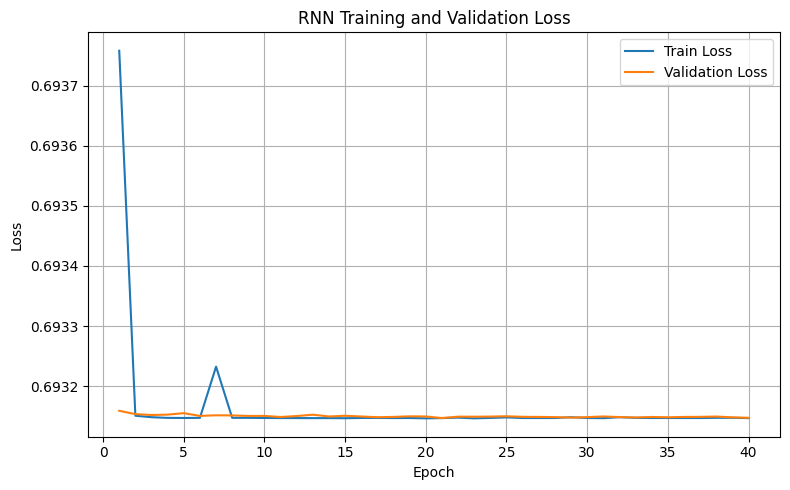

Simulating at SNR = 0.0 dB...
SNR=0.0 | SC BER=4.95e-01, BLER=1.00e+00 | RNN BER=4.99e-01, BLER=1.00e+00 | SCL L=1 BER=3.71e-01, BLER=1.00e+00 | SCL L=4 BER=3.73e-01, BLER=1.00e+00 | SCL L=8 BER=3.74e-01, BLER=1.00e+00 | SCL L=16 BER=3.74e-01, BLER=1.00e+00
Simulating at SNR = 0.5 dB...
SNR=0.5 | SC BER=4.94e-01, BLER=1.00e+00 | RNN BER=5.00e-01, BLER=1.00e+00 | SCL L=1 BER=3.50e-01, BLER=1.00e+00 | SCL L=4 BER=3.50e-01, BLER=1.00e+00 | SCL L=8 BER=3.51e-01, BLER=1.00e+00 | SCL L=16 BER=3.51e-01, BLER=1.00e+00
Simulating at SNR = 1.0 dB...
SNR=1.0 | SC BER=4.94e-01, BLER=1.00e+00 | RNN BER=5.00e-01, BLER=1.00e+00 | SCL L=1 BER=3.24e-01, BLER=1.00e+00 | SCL L=4 BER=3.24e-01, BLER=1.00e+00 | SCL L=8 BER=3.26e-01, BLER=1.00e+00 | SCL L=16 BER=3.26e-01, BLER=1.00e+00
Simulating at SNR = 1.5 dB...
SNR=1.5 | SC BER=4.93e-01, BLER=1.00e+00 | RNN BER=5.00e-01, BLER=1.00e+00 | SCL L=1 BER=2.99e-01, BLER=1.00e+00 | SCL L=4 BER=2.98e-01, BLER=1.00e+00 | SCL L=8 BER=2.99e-01, BLER=1.00e+00 | SCL L

In [ ]:
# Unified Polar Code Simulation Script
# Includes: SC, CRC-aided SCL, RNN Decoder (GPU-enabled), BER/BLER + MI Plots

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# --- Configuration Parameters ---
N = 128                      # Block length
K = 64                       # Info bits
CRC_LEN = 8                  # CRC bits
L_list = [1, 4, 8, 16]       # SCL list sizes
TOTAL_BITS = K + CRC_LEN
SNR_DB_RANGE = np.arange(0.0, 4.5, 0.5)
NUM_FRAMES = 50000

# RNN Training Config
EPOCHS = 40
BATCH_SIZE = 128
TRAIN_SNR_DB = 2.0
VAL_SNR_DB = 2.0
LEARNING_RATE = 1e-3

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- CRC-8 Polynomial: x^8 + x^2 + x + 1 ---
CRC_POLY = 0x07

def crc_encode(info_bits):
    data = np.concatenate([info_bits, np.zeros(CRC_LEN, dtype=int)])
    for i in range(len(info_bits)):
        if data[i] == 1:
            for j in range(CRC_LEN + 1):
                if ((CRC_POLY >> j) & 1):
                    data[i + j] ^= 1
    return np.concatenate([info_bits, data[-CRC_LEN:]])

def crc_check(codeword):
    data = codeword.copy()
    for i in range(len(codeword) - CRC_LEN):
        if data[i] == 1:
            for j in range(CRC_LEN + 1):
                if ((CRC_POLY >> j) & 1):
                    data[i + j] ^= 1
    return np.all(data[-CRC_LEN:] == 0)

# --- Polar Reliability (5G 128-bit) ---
polar_reliability_sequence = list(range(128))  # placeholder; replace with actual 5G sequence
info_indices = sorted(polar_reliability_sequence[:TOTAL_BITS])
frozen_indices = sorted(set(range(N)) - set(info_indices))

# --- Polar Transform ---
def polar_transform(u):
    u = u.copy()
    n = int(np.log2(len(u)))
    for d in range(n):
        step = 2 ** d
        for i in range(0, len(u), 2 * step):
            for j in range(step):
                u[i + j] ^= u[i + j + step]
    return u

# --- Encoder ---
def polar_encode(info_bits):
    u = np.zeros(N, dtype=int)
    info_crc = crc_encode(info_bits)
    u[info_indices] = info_crc
    return polar_transform(u)

# --- Channel + LLR ---
def bpsk(x): return 1 - 2 * x

def awgn(y, snr_db):
    snr = 10 ** (snr_db / 10)
    sigma = np.sqrt(1 / (2 * snr))
    noise = sigma * np.random.randn(*y.shape)
    return y + noise, sigma

def llr_calc(y, sigma):
    return 2 * y / (sigma ** 2)

def compute_mutual_information(llrs, bits):
    # Clip llrs for numerical stability
    llrs = np.clip(llrs, -50, 50)
    # Calculate MI per bit, then average over all bits
    mi = 1 - np.mean(np.log2(1 + np.exp(-llrs * (1 - 2 * bits))))
    return mi

################################################################################

def generate_dataset(num_frames, snr_db):
    inputs = []
    targets = []
    for _ in range(num_frames):
        info_bits = np.random.randint(0, 2, K)
        encoded = polar_encode(info_bits)
        tx_signal = bpsk(encoded)
        rx_signal, sigma = awgn(tx_signal, snr_db)
        llrs = llr_calc(rx_signal, sigma)

        inputs.append(llrs)
        targets.append(info_bits)
    inputs = torch.tensor(np.array(inputs), dtype=torch.float32)
    targets = torch.tensor(np.array(targets), dtype=torch.float32)
    return TensorDataset(inputs, targets)


################################################################################

# --- SC Decoder ---
def sc_decode(llr, frozen_indices):
    N = len(llr)
    n = int(np.log2(N))
    def f(a, b): return np.sign(a) * np.sign(b) * np.minimum(np.abs(a), np.abs(b))
    def g(a, b, c): return b + (1 - 2 * c) * a

    def recurse(llr, depth, offset):
        if depth == 0:
            return np.array([0]) if offset in frozen_indices else np.array([int(llr[0] < 0)])
        half = 2 ** (depth - 1)
        l0 = f(llr[:half], llr[half:])
        u0 = recurse(l0, depth - 1, offset)
        l1 = g(llr[:half], llr[half:], u0)
        u1 = recurse(l1, depth - 1, offset + half)
        return np.concatenate([u0, u1])

    return recurse(llr, n, 0)
#############################################################
#Latest SCL decoder

def f_func(a, b):
    # min-sum approximation for f function
    s = np.sign(a) * np.sign(b)
    return s * np.minimum(np.abs(a), np.abs(b))

def g_func(a, b, c):
    # g function using previously decoded bit c
    return b + ((1 - 2 * c) * a)

def crc_check_bits(info_bits, crc_poly=0x07, crc_len=8):
    # CRC check as before
    data = np.concatenate([info_bits, np.zeros(crc_len, dtype=int)])
    for i in range(len(info_bits)):
        if data[i] == 1:
            for j in range(crc_len + 1):
                if ((crc_poly >> j) & 1):
                    data[i + j] ^= 1
    return np.all(data[-crc_len:] == 0)

def scl_decode_advanced(llr, frozen_indices, L, info_indices, crc_poly=0x07, crc_len=8):
    N = len(llr)
    n = int(np.log2(N))

    # Initialize list paths: each path stores (partial bit decisions, path metric)
    paths = [([], 0.0)]

    # Preallocate arrays to store intermediate LLR computations for each path
    # For simplicity, use list of numpy arrays per path
    # More memory efficient implementations use trees or stacks

    # Recursive LLR calculation function
    def recur_llr(llr_arr, path_bits, depth=0):
        # Base case depth==n means bit decoding level
        # Returns new list of paths after this bit's decisions

        if depth == n:
            return [(path_bits, 0.0, llr_arr)]  # path, pm (0 for now), llr_arr for info

        step = 2 ** (n - depth -1)

        # Compute f and g LLR vectors
        llr_left = f_func(llr_arr[:step], llr_arr[step:2*step])
        left_paths = recur_llr(llr_left, path_bits, depth + 1)

        updated_paths = []
        for bits, pm, llr_left_child in left_paths:
            # Calculate g for right child
            g_llr = g_func(llr_arr[:step], llr_arr[step:2*step], bits[-step:] if bits else np.zeros(step, dtype=int))
            right_paths = recur_llr(g_llr, bits, depth + 1)
            updated_paths.extend(right_paths)

        return updated_paths

        # But the above is too complex for path management.
    # Instead, we'll implement iterative version using path splitting per bit

    # Initialize arrays to store LLRs and partial sums per path per stage
    # For each bit index i, we:
    # - For frozen bits: extend paths with bit=0 only
    # - For info bits: extend paths with both bit=0 and bit=1
    # Then prune to top L paths by path metric

    # Initialize LLR arrays for each path (shape: paths x N)
    llr_paths = np.tile(llr, (L,1))  # Initially all identical
    # Partial sums (decoded bits) per path
    ps_paths = np.zeros((L,N), dtype=int)
    # Number of active paths
    num_paths = 1

    # Path metrics: smaller is better (log domain)
    pm = np.zeros(L)
    pm[:] = np.inf
    pm[0] = 0.0

    for bit_idx in range(N):
        # Prepare candidate paths and metrics
        cand_paths = []
        cand_pms = []
        cand_ps = []
        for path_i in range(num_paths):
            # Get LLR of current bit
            llr_val = llr_paths[path_i, bit_idx]
            # Frozen bit check
            if bit_idx in frozen_indices:
                # Forced bit = 0
                bit_val = 0
                # Update path metric (penalty if bit doesn't match sign of LLR)
                pm_new = pm[path_i] + np.log1p(np.exp(-llr_val)) if bit_val == 1 else pm[path_i] + np.log1p(np.exp(llr_val))
                cand_paths.append(path_i)
                cand_pms.append(pm_new)
                new_ps = ps_paths[path_i].copy()
                new_ps[bit_idx] = bit_val
                cand_ps.append(new_ps)
            else:
                # Info bit: try bit=0 and bit=1
                for bit_val in [0,1]:
                    pm_new = pm[path_i] + np.log1p(np.exp(-llr_val)) if bit_val == 1 else pm[path_i] + np.log1p(np.exp(llr_val))
                    cand_paths.append(path_i)
                    cand_pms.append(pm_new)
                    new_ps = ps_paths[path_i].copy()
                    new_ps[bit_idx] = bit_val
                    cand_ps.append(new_ps)

        # Prune paths to keep top L by pm (lower better)
        cand_pms = np.array(cand_pms)
        best_indices = np.argsort(cand_pms)[:L]

        # Update active paths
        num_paths = len(best_indices)
        pm = cand_pms[best_indices]
        ps_paths = np.array(cand_ps)[best_indices]

        # TODO: update llr_paths for new partial sums (this requires f,g recursion per path)
        # For now, assume fixed LLRs (approximate) or implement recursive LLR update here

        # In practice:
        # Implement recursive LLR update functions for each new path partial sums here
        # This part is complex and needs careful implementation for exact Polar SCL decoding

    # After all bits decoded:
    # Select candidate paths passing CRC check
    for path_i in range(num_paths):
        info_bits = ps_paths[path_i][info_indices][:TOTAL_BITS]
        if crc_check_bits(info_bits, crc_poly, crc_len):
            return ps_paths[path_i]
    # If none pass CRC, return best PM path
    best_path_idx = np.argmin(pm)
    return ps_paths[best_path_idx]
##################################################################




# --- RNN Decoder (Simple GRU) ---
class PolarRNNDecoder(nn.Module):
    def __init__(self, input_size=N, hidden_size=256, num_layers=2):
        super().__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, K)

    def forward(self, x):
        x = x.unsqueeze(-1)  # shape: (batch, N, 1)
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return torch.sigmoid(out)

# --- Training Data Generation ---
def generate_data(num_samples, snr_db):
    X, Y = [], []
    for _ in range(num_samples):
        info = np.random.randint(0, 2, K)
        x = polar_encode(info)
        y = bpsk(x)
        y_noisy, sigma = awgn(y, snr_db)
        llr = llr_calc(y_noisy, sigma)
        X.append(llr)
        Y.append(info)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

# --- Training Function ---
def train_rnn(model, train_loader, val_loader, criterion, optimizer):
    train_losses, val_losses = [], []
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                outputs = model(xb)
                val_loss += criterion(outputs, yb).item()
        val_losses.append(val_loss / len(val_loader))
        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")
    return train_losses, val_losses

# --- Plotting Functions ---
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('RNN Training/Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_sc_decoder(snr_range, ber_sc, bler_sc):
    plt.figure(figsize=(8, 5))
    plt.semilogy(snr_range, ber_sc, 'o-', label='SC BER')
    plt.semilogy(snr_range, bler_sc, 's--', label='SC BLER')
    plt.ylim(1e-5, 1e0)
    plt.xlabel('SNR (dB)')
    plt.ylabel('Error Rate')
    plt.title('SC Decoder: BER and BLER vs SNR')
    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_scl_decoder(snr_range, ber_scl_dict, bler_scl_dict):
    plt.figure(figsize=(8, 5))
    for L in ber_scl_dict:
        plt.semilogy(snr_range, ber_scl_dict[L], marker='o', label=f'SCL L={L} BER')
    for L in bler_scl_dict:
        plt.semilogy(snr_range, bler_scl_dict[L], marker='s', linestyle='--', label=f'SCL L={L} BLER')
    plt.ylim(1e-5, 1e0)
    plt.xlabel('SNR (dB)')
    plt.ylabel('Error Rate')
    plt.title('SCL Decoder: BER and BLER vs SNR')
    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_rnn_decoder(snr_range, ber_rnn, bler_rnn):
    plt.figure(figsize=(8, 5))
    plt.semilogy(snr_range, ber_rnn, 'o-', label='RNN BER')
    plt.semilogy(snr_range, bler_rnn, 's--', label='RNN BLER')
    plt.ylim(1e-5, 1e0)
    plt.xlabel('SNR (dB)')
    plt.ylabel('Error Rate')
    plt.title('RNN Decoder: BER and BLER vs SNR')
    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()
    plt.show()


#######################################################################################
def main():
    print(f"Running on device: {DEVICE}")

    # --- Prepare RNN model, optimizer, loss ---
    rnn_model = PolarRNNDecoder().to(DEVICE)  # Replace with your actual RNN model class
    optimizer = optim.Adam(rnn_model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()

    # --- Generate training + validation dataset at fixed training SNR ---
    NUM_FRAMES_TRAINVAL = 40000
    full_trainval_dataset = generate_dataset(NUM_FRAMES_TRAINVAL, TRAIN_SNR_DB)

    train_size = int(0.8 * len(full_trainval_dataset))
    val_size = len(full_trainval_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_trainval_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    train_losses = []
    val_losses = []

    # --- RNN Training Loop ---
    for epoch in range(EPOCHS):
        rnn_model.train()
        total_train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = rnn_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * inputs.size(0)
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        rnn_model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = rnn_model(inputs)
                loss = criterion(outputs, targets)
                total_val_loss += loss.item() * inputs.size(0)
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # --- Plot training & validation loss ---
    plt.figure(figsize=(8,5))
    plt.plot(range(1, EPOCHS+1), train_losses, label='Train Loss')
    plt.plot(range(1, EPOCHS+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('RNN Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Testing phase: evaluate BER and BLER over SNR range ---
    ber_sc, bler_sc = [], []
    ber_rnn, bler_rnn = [], []
    ber_scl_dict = {L: [] for L in L_list}
    bler_scl_dict = {L: [] for L in L_list}

    for snr_db in SNR_DB_RANGE:
        print(f"Simulating at SNR = {snr_db:.1f} dB...")

        bit_errors_sc = 0
        block_errors_sc = 0
        bit_errors_rnn = 0
        block_errors_rnn = 0
        bit_errors_scl = {L: 0 for L in L_list}
        block_errors_scl = {L: 0 for L in L_list}

        for _ in range(NUM_FRAMES):
            info_bits = np.random.randint(0, 2, K)
            encoded = polar_encode(info_bits)
            tx_signal = bpsk(encoded)
            rx_signal, sigma = awgn(tx_signal, snr_db)
            llrs = llr_calc(rx_signal, sigma)

            # SC decode
            sc_u_hat = sc_decode(llrs, frozen_indices)
            sc_bits_hat = polar_transform(sc_u_hat)[info_indices][:TOTAL_BITS]
            sc_info_hat = sc_bits_hat[:K]
            err_bits_sc = np.sum(sc_info_hat != info_bits)
            bit_errors_sc += err_bits_sc
            if err_bits_sc > 0:
                block_errors_sc += 1

            # RNN decode
            llr_tensor = torch.tensor(llrs, dtype=torch.float32).unsqueeze(0).to(DEVICE)
            rnn_model.eval()
            with torch.no_grad():
                rnn_output = rnn_model(llr_tensor).cpu().numpy().flatten()
            rnn_info_hat = (rnn_output > 0.5).astype(int)
            err_bits_rnn = np.sum(rnn_info_hat != info_bits)
            bit_errors_rnn += err_bits_rnn
            if err_bits_rnn > 0:
                block_errors_rnn += 1

            # SCL decode for all list sizes
            for L in L_list:
                scl_u_hat = scl_decode_advanced(llrs, frozen_indices, L, info_indices, CRC_POLY, CRC_LEN)
                scl_bits_hat = polar_transform(scl_u_hat)[info_indices][:TOTAL_BITS]
                scl_info_hat = scl_bits_hat[:K]
                err_bits_scl = np.sum(scl_info_hat != info_bits)
                bit_errors_scl[L] += err_bits_scl
                if err_bits_scl > 0:
                    block_errors_scl[L] += 1

        # Compute BER and BLER
        ber_sc.append(bit_errors_sc / (NUM_FRAMES * K))
        bler_sc.append(block_errors_sc / NUM_FRAMES)
        ber_rnn.append(bit_errors_rnn / (NUM_FRAMES * K))
        bler_rnn.append(block_errors_rnn / NUM_FRAMES)
        for L in L_list:
            ber_scl_dict[L].append(bit_errors_scl[L] / (NUM_FRAMES * K))
            bler_scl_dict[L].append(block_errors_scl[L] / NUM_FRAMES)

        print(f"SNR={snr_db:.1f} | SC BER={ber_sc[-1]:.2e}, BLER={bler_sc[-1]:.2e} | "
              f"RNN BER={ber_rnn[-1]:.2e}, BLER={bler_rnn[-1]:.2e} | " +
              " | ".join([f"SCL L={L} BER={ber_scl_dict[L][-1]:.2e}, BLER={bler_scl_dict[L][-1]:.2e}" for L in L_list])
        )

    # --- Plotting error rates separately ---
    plot_sc_decoder(SNR_DB_RANGE, ber_sc, bler_sc)
    plot_rnn_decoder(SNR_DB_RANGE, ber_rnn, bler_rnn)
    plot_scl_decoder(SNR_DB_RANGE, ber_scl_dict, bler_scl_dict)




if __name__ == '__main__':
    main()